In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [3]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

### Dataset

In [4]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [5]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

610
9724


# Spotlight

### Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used if needed.

In [7]:
from collections import defaultdict
from itertools import count

uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 2518


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

### Implicit Factorization model

In [8]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
#val split!
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))

In [9]:
print(implicit_train)
print(implicit_test)
print(implicit_val)

<Interactions dataset (610 users x 9724 items x 64534 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>
<Interactions dataset (610 users x 9724 items x 16134 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [10]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId']==converted_movies[i]) & (ratings_df['userId']==converted_users[i])].values))

    df = pd.DataFrame({'user_id':converted_users,'movie_id':converted_movies,'rating':rating})
    return df

In [11]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)

### Implicit Factorization model implementation

In [12]:
implicit_model  = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

implicit_model.fit(implicit_train,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.7449644295123254
Epoch 1: loss 0.44551400374989264
Epoch 2: loss 0.4042296750036624
Epoch 3: loss 0.36906998136297986
Epoch 4: loss 0.3319073737609999
Training took 61 second


MRR score of the Implicit recommender

In [13]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

0.27813369128149507


Distribution of scores for a user

(array([  27.,  126.,  411., 1080., 1701., 1448.,  951.,  566.,  363.,
         272.,  231.,  199.,  172.,  169.,  123.,  121.,  131.,  106.,
         109.,  115.,   98.,   94.,  120.,  105.,   82.,   92.,   96.,
          86.,   98.,   85.,   90.,   72.,   58.,   41.,   24.,   21.,
          19.,   13.,    7.,    2.]),
 array([-12.403477  , -11.668647  , -10.933817  , -10.198987  ,
         -9.464156  ,  -8.729326  ,  -7.9944963 ,  -7.2596664 ,
         -6.5248365 ,  -5.790006  ,  -5.0551763 ,  -4.3203464 ,
         -3.5855162 ,  -2.850686  ,  -2.1158562 ,  -1.381026  ,
         -0.646196  ,   0.08863406,   0.8234641 ,   1.5582942 ,
          2.2931242 ,   3.0279543 ,   3.7627842 ,   4.4976144 ,
          5.2324443 ,   5.9672747 ,   6.7021046 ,   7.4369345 ,
          8.171764  ,   8.906594  ,   9.641424  ,  10.376255  ,
         11.111085  ,  11.845915  ,  12.580745  ,  13.315575  ,
         14.050405  ,  14.785235  ,  15.520065  ,  16.254894  ,
         16.989725  ], dtype=float32),

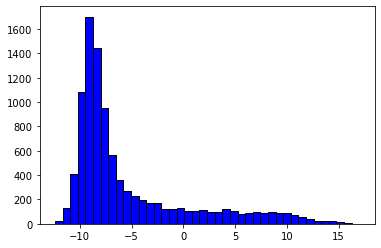

In [14]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

In [15]:
import scipy.stats as st

def topK_implicit(user, k=100):
  a= list()
  ranks = st.rankdata(-implicit_model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0)
print(rec_forUser)

[1, 6, 47, 50, 110, 223, 231, 235, 260, 296, 316, 349, 356, 367, 457, 480, 500, 527, 590, 592, 593, 596, 608, 648, 733, 736, 780, 1136, 1196, 1197, 1198, 1265, 1270, 1580, 2858, 318, 31, 21, 32, 357, 368, 539, 588, 595, 1391, 2762, 34, 39, 150, 153, 253, 300, 344, 364, 380, 410, 474, 589, 594, 597, 2, 10, 16, 19, 25, 62, 95, 104, 160, 161, 165, 185, 208, 288, 292, 293, 317, 329, 337, 339, 350, 353, 377, 440, 454, 508, 520, 587, 586, 1200, 111, 745, 1193, 1036, 442, 555, 778, 173, 551, 1393]


In [16]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
9,10,GoldenEye (1995),Action|Adventure|Thriller
15,16,Casino (1995),Crime|Drama
...,...,...,...
1071,1391,Mars Attacks! (1996),Action|Comedy|Sci-Fi
1073,1393,Jerry Maguire (1996),Drama|Romance
1183,1580,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi
2078,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery


In [17]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Actual movies watched

In [18]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [19]:
actual = actual.index.tolist()

In [20]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
5,6,Heat (1995),Action|Crime|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
62,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
...,...,...,...
1332,1804,"Newton Boys, The (1998)",Crime|Drama
1333,1805,Wild Things (1998),Crime|Drama|Mystery|Thriller
1401,1920,Small Soldiers (1998),Animation|Children|Fantasy|War
2991,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [21]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score for each user

### Note: The implementation below is the NDCG score for the first user only! I will include them all with a loop, but to avoid the loss of time I will do it after the solution is finalized and thought as correct!

In [22]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [23]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [24]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [25]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [26]:
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.7675031693134161


# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [27]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [28]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190215,193565,193571,193573,193579,193581,193583,193609
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)


To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [30]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [31]:
svd_predictions_score[0]

array([ 1.53311989,  0.320757  ,  0.40399314, ..., -0.00710874,
       -0.00622015, -0.00270554])

In [32]:
svd_predictions_score_df[47][609]

4.515674043311323

In [33]:
svd_predictions_score_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190215,193565,193571,193573,193579,193581,193583,193609
0,1.533120,0.320757,0.403993,-0.016015,0.145622,1.317496,-0.003277,0.016531,0.073275,1.119262,...,0.002456,0.000614,0.000921,-0.006220,-0.007109,-0.007109,-0.006220,-0.007109,-0.006220,-0.002706
1,0.095577,0.056775,-0.057698,-0.005455,0.003629,-0.019466,-0.043983,-0.004939,-0.004896,-0.075899,...,0.001000,0.000250,0.000375,0.002286,0.002612,0.002612,0.002286,0.002612,0.002286,0.008886
2,0.038897,-0.002693,0.009487,-0.002578,-0.007252,0.063302,-0.014916,-0.001135,0.000605,0.050043,...,-0.000231,-0.000058,-0.000087,-0.000257,-0.000294,-0.000294,-0.000257,-0.000294,-0.000257,-0.002190
3,0.737799,-0.023450,0.074980,0.006094,0.006077,0.589714,0.033889,-0.069677,-0.012867,0.164856,...,0.001171,0.000293,0.000439,-0.000358,-0.000410,-0.000410,-0.000358,-0.000410,-0.000358,-0.000036
4,0.970353,0.625992,0.278857,0.104282,0.396265,0.189305,0.402911,0.039767,0.025190,0.762817,...,0.002805,0.000701,0.001052,-0.000168,-0.000193,-0.000193,-0.000168,-0.000193,-0.000168,-0.001854


In [34]:
svd_predictions_score_df[svd_predictions_score_df.index == 2]

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190213,190215,193565,193571,193573,193579,193581,193583,193609
2,0.038897,-0.002693,0.009487,-0.002578,-0.007252,0.063302,-0.014916,-0.001135,0.000605,0.050043,...,-0.000231,-0.000058,-0.000087,-0.000257,-0.000294,-0.000294,-0.000257,-0.000294,-0.000257,-0.00219


In [35]:
len(svd_predictions_score[0])

8263

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [36]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [37]:
already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
already_rated.head()

,userId,movieId,rating,timestamp,title,genres
231,1,5060,5.0,964984002,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
185,1,2872,5.0,964981680,Excalibur (1981),Adventure|Fantasy
89,1,1291,5.0,964981909,Indiana Jones and the Last Crusade (1989),Action|Adventure
90,1,1298,5.0,964984086,Pink Floyd: The Wall (1982),Drama|Musical
190,1,2948,5.0,964982191,From Russia with Love (1963),Action|Adventure|Thriller


In [38]:
predictions

,movieId,title,genres,movie_id
1896,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,2762.0
615,858,"Godfather, The (1972)",Crime|Drama,858.0
844,1221,"Godfather: Part II, The (1974)",Crime|Drama,1221.0
475,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,589.0
736,1036,Die Hard (1988),Action|Crime|Thriller,1036.0
...,...,...,...,...
846,1225,Amadeus (1984),Drama,1225.0
472,586,Home Alone (1990),Children|Comedy,586.0
2152,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3114.0
1583,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,2324.0


In [39]:
predicted_rank_svd = predictions['movieId'].index.tolist()

In [40]:
relevance_SVD = []
for i in range(len(predicted_rank_svd)):
    if predicted_rank_svd[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_SVD.append(1)
    else:
        relevance_SVD.append(0)

In [41]:
ndcg = NDCG_forUser(relevance_SVD)
print(ndcg)

0.21696290339800392


# LightGBM Baseline

I create 2 features, which are the scores from the Implicit and SVD models on the top-K recommendations for each user based on the implicit model.

In [42]:
target_movies = []
for i in range(len(num_users)):
    target_movies.append(topK_implicit(i))

Map the target movies to pick the correct predictions based on the item id

In [43]:
map_target_movies = []
map_help = []
for movies in target_movies:
    for movie in movies:
        map_help.append(iid_map[movie])
    map_target_movies.append(map_help)
    map_help = []

Implicit Factorization model Scores

In [44]:
implicit_scores = []
for movies in map_target_movies:
    my_list = movies
    my_array = np.array(my_list)
    implicit_scores.append(implicit_model.predict(user_ids = 0,item_ids = my_array))
feature1 = implicit_scores

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [45]:
feature2 = []
helper = []
for i in range(len(num_users)):
    for movie in target_movies[i]:
        helper.append(svd_predictions_score_df[movie][i])
    feature2.append(helper)
    helper = []

In [46]:
f_df = pd.DataFrame({'feature 1':feature1,'feature 2':feature2})

In [47]:
f_df

,feature 1,feature 2
0,"[14.774545, 12.442005, 15.161607, 14.960799, 1...","[1.533119888444623, 1.3174962707964255, 1.2803..."
1,"[14.774545, 12.442005, 15.161607, 14.960799, 1...","[0.09557720026254937, -0.019466254845465335, 0..."
2,"[14.774545, 12.442005, 15.161607, 14.960799, 1...","[0.038897455402696526, 0.06330176087863994, -0..."
3,"[14.774545, 12.442005, 15.161607, 14.960799, 1...","[0.7377993665385579, 0.5897144636345678, 0.680..."
4,"[14.774545, 15.161607, 14.960799, 16.03776, 11...","[0.970353460449888, 0.8769236680000422, 0.7406..."
...,...,...
605,"[14.739657, 11.215093, 9.384729, 12.887171, 11...","[-1.8318994419645285, 3.4213932692418423, 0.45..."
606,"[14.774545, 11.471466, 15.161607, 14.960799, 1...","[1.7913793051792717, 0.47592409754951254, 1.28..."
607,"[14.774545, 15.161607, 14.960799, 16.03776, 13...","[1.736500854743636, 2.7460450322796373, 2.1604..."
608,"[14.774545, 15.161607, 14.960799, 16.03776, 10...","[1.004207730708319, 1.0638754504790586, 0.9137..."


In [48]:
features = np.stack((feature1,feature2))
features

array([[[ 1.47745447e+01,  1.24420052e+01,  1.51616068e+01, ...,
          1.26348114e+01,  1.37623186e+01,  1.27035761e+01],
        [ 1.47745447e+01,  1.24420052e+01,  1.51616068e+01, ...,
          7.51575756e+00,  9.88974953e+00,  4.91457224e+00],
        [ 1.47745447e+01,  1.24420052e+01,  1.51616068e+01, ...,
          1.01740828e+01,  8.97584629e+00,  1.18066378e+01],
        ...,
        [ 1.47745447e+01,  1.51616068e+01,  1.49607992e+01, ...,
          1.00835876e+01,  1.06064434e+01,  1.27035761e+01],
        [ 1.47745447e+01,  1.51616068e+01,  1.49607992e+01, ...,
          8.09914589e+00,  1.18066378e+01,  7.58115673e+00],
        [ 1.09754181e+01, -1.37238181e+00,  3.67560840e+00, ...,
         -4.88244438e+00, -6.59475756e+00,  3.76473141e+00]],

       [[ 1.53311989e+00,  1.31749627e+00,  1.28037014e+00, ...,
          2.90603425e-01,  5.01381975e-01,  8.04713007e-01],
        [ 9.55772003e-02, -1.94662548e-02,  2.76401131e-01, ...,
          2.79703060e-01,  7.28780898e

Below are the movies that each user watched

In [49]:
watched = []
for i in range(len(num_users)):
    watched.append(ratings_df[ratings_df["userId"]==uid_rev_map.get(i)].groupby("movieId")["movieId"].count().index)  

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [50]:
user_target = []
target = []
for i in range(len(num_users)):
    for target_movie in target_movies[i]:
        if target_movie in watched[i]:
            user_target.append(1)
        else:
            user_target.append(0)
    target.append(user_target)
    user_target = []

In [51]:
watched[0]

Int64Index([   1,    3,    6,   47,   50,   70,  101,  110,  151,  157,
            ...
            3671, 3702, 3703, 3729, 3740, 3744, 3793, 3809, 4006, 5060],
           dtype='int64', name='movieId', length=232)

In [52]:
592 in watched[0]

True

In [53]:
X = np.array(features)
y = np.array(target)

In [54]:
X = X.reshape(61000, 2)


In [55]:
X.shape

(61000, 2)

In [56]:
y = y.reshape(61000,)

In [57]:
y.shape

(61000,)

In [87]:
import lightgbm as lgb
gbm = lgb.LGBMRanker()

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [60]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)

for i in range(390):
    group_train.append(100)
group_train.append(40)
group_val.append(60)
for i in range(97):
    group_val.append(100)


[39040]
[9760]
[12200]


In [61]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[5, 10, 20], early_stopping_rounds=50)
#group – Group data of training data.

[1]	valid_0's ndcg@5: 0.270007	valid_0's ndcg@10: 0.275747	valid_0's ndcg@20: 0.277539
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@5: 0.278668	valid_0's ndcg@10: 0.283254	valid_0's ndcg@20: 0.284841
[3]	valid_0's ndcg@5: 0.289278	valid_0's ndcg@10: 0.291418	valid_0's ndcg@20: 0.283872
[4]	valid_0's ndcg@5: 0.28065	valid_0's ndcg@10: 0.285715	valid_0's ndcg@20: 0.275834
[5]	valid_0's ndcg@5: 0.287389	valid_0's ndcg@10: 0.279425	valid_0's ndcg@20: 0.278595
[6]	valid_0's ndcg@5: 0.277048	valid_0's ndcg@10: 0.281548	valid_0's ndcg@20: 0.280394
[7]	valid_0's ndcg@5: 0.284648	valid_0's ndcg@10: 0.280879	valid_0's ndcg@20: 0.280109
[8]	valid_0's ndcg@5: 0.276931	valid_0's ndcg@10: 0.272382	valid_0's ndcg@20: 0.281088
[9]	valid_0's ndcg@5: 0.274715	valid_0's ndcg@10: 0.273717	valid_0's ndcg@20: 0.275608
[10]	valid_0's ndcg@5: 0.281333	valid_0's ndcg@10: 0.27216	valid_0's ndcg@20: 0.277736
[11]	valid_0's ndcg@5: 0.279404	valid_0's ndcg@10: 0.268453	valid_0's 

LGBMRanker()

In [62]:
test_pred = gbm.predict(X_test)

In [63]:
test_pred

array([-0.02374372, -0.04656897, -0.0061143 , ..., -0.00911849,
        0.03979368, -0.0061143 ])

# Draft

In [64]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

In [65]:
ndcg

0.8091987625401954

In [66]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

0.8091987625401954

In [67]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

'relevance = []\nfor i in range(20,40):\n    if predicted_rank_svd[i] in actual:\n        relevance.append(1)\n    else:\n        relevance.append(0)'

In [68]:
svd_rank_allUsers = []
for i in range(1,611):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [69]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

'def NDCG_forUser_SVD(user):\n    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'

In [70]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

'NDCG_SVD = NDCG_forUser_SVD(2)'

In [71]:
'''NDCG_SVD'''

'NDCG_SVD'

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

### Embeddings 

In [72]:
emb = implicit_model._net.item_embeddings.weight[9723]
emb = emb.tolist()
print(len(emb))

32


In [73]:
#Input
#svd_predictions_score
#predicted_rank_svd
#emb
#l_rec (rank recommendations)

In [74]:
svd_predictions_score.shape


(610, 8263)

In [75]:
import lightgbm as lgb
gbm = lgb.LGBMRanker()

In [76]:
from sklearn.model_selection import train_test_split

# KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [77]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [78]:
df_movie_features

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


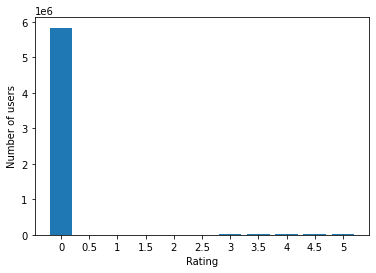

In [79]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [80]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

NameError: name 'df_movies_cnt' is not defined

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]